# Plant disease detection

### Configuration

In [1]:
# auth
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

# mount google drive
!mkdir -p drive
!google-drive-ocamlfuse drive

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18408 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Selecting previously unselected package dirmngr.
Preparing to unpack .../04-dirmngr_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking dirmngr (2.1.15-1ubuntu8.1) ...
Selecting previously unselected package distro-info-data.
Preparing to unpack .

### Dependencies


In [2]:
# install dependencies
!pip install keras==2.1.6
!pip install keras-vis==0.4.1

In [3]:
# import dependencies
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import Sequence
from keras.utils import np_utils
from keras.applications.resnet50 import ResNet50

import numpy as np

import os

import matplotlib.pyplot as plt

from PIL import Image

Using TensorFlow backend.


### Classes

List of classes:
*   Apple: Apple scab
*   Apple: Black rot
*   Apple: Cedar apple rust
*   Apple: healthy
*   Blueberry: healthy
*   Cherry (including sour): healthy
*   Cherry (including sour): Powdery mildew
*   Corn (maize): Cercospora leaf spot, Gray leaf spot
*   Corn (maize): Common rust
*   Corn (maize): healthy
*   Corn (maize): Northern Leaf Blight
*   Grape: Black rot
*   Grape: Esca (Black Measles)
*   Grape: healthy
*   Grape: Leaf blight (Isariopsis Leaf Spot)
*   Orange: Haunglongbing (Citrus greening)
*   Peach: Bacterial spot
*   Peach: healthy
*   Pepper bell: Bacterial spot
*   Pepper bell: healthy
*   Potato: Early blight
*   Potato: healthy
*   Potato: Late blight
*   Raspberry: healthy
*   Soybean: healthy
*   Squash: Powdery mildew
*   Strawberry: healthy
*   Strawberry: Leaf scorch
*   Tomato: Bacterial spot
*   Tomato: Early blight
*   Tomato: healthy
*   Tomato: Late blight
*   Tomato: Leaf Mold
*   Tomato: Septoria leaf spot
*   Tomato: Spider mites, Two spotted spider mite
*   Tomato: Target Spot
*   Tomato: Tomato mosaic virus
*   Tomato: Tomato Yellow Leaf Curl Virus

In [0]:
# define classes
classes = {
    'Apple___Apple_scab': 0,
    'Apple___Black_rot': 1,
    'Apple___Cedar_apple_rust': 2,
    'Apple___healthy': 3,
    'Blueberry___healthy': 4,
    'Cherry_(including_sour)___healthy': 5,
    'Cherry_(including_sour)___Powdery_mildew': 6,
    'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
    'Corn_(maize)___Common_rust_': 8,
    'Corn_(maize)___healthy': 9,
    'Corn_(maize)___Northern_Leaf_Blight': 10,
    'Grape___Black_rot': 11,
    'Grape___Esca_(Black_Measles)': 12,
    'Grape___healthy': 13,
    'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 14,
    'Orange___Haunglongbing_(Citrus_greening)': 15,
    'Peach___Bacterial_spot': 16,
    'Peach___healthy': 17,
    'Pepper,_bell___Bacterial_spot': 18,
    'Pepper,_bell___healthy': 19,
    'Potato___Early_blight': 20,
    'Potato___healthy': 21,
    'Potato___Late_blight': 22,
    'Raspberry___healthy': 23,
    'Soybean___healthy': 24,
    'Squash___Powdery_mildew': 25,
    'Strawberry___healthy': 26,
    'Strawberry___Leaf_scorch': 27,
    'Tomato___Bacterial_spot': 28,
    'Tomato___Early_blight': 29,
    'Tomato___healthy': 30,
    'Tomato___Late_blight': 31,
    'Tomato___Leaf_Mold': 32,
    'Tomato___Septoria_leaf_spot': 33,
    'Tomato___Spider_mites Two-spotted_spider_mite': 34,
    'Tomato___Target_Spot': 35,
    'Tomato___Tomato_mosaic_virus': 36,
    'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 37
}

### Data


In [5]:
# fetch dataset
!git clone https://github.com/lzoran/plant-disease-dataset.git
# genereate train and test sets
%cd plant-disease-dataset
!rm -rf train
!rm -rf test
!python3 -c 'from build_dataset import build_dataset; build_dataset()'
%cd ../
# display dataset structure
!ls plant-disease-dataset

Cloning into 'plant-disease-dataset'...
remote: Counting objects: 54328, done.
remote: Compressing objects: 100% (54326/54326), done.
remote: Total 54328 (delta 0), reused 54328 (delta 0), pack-reused 0
Receiving objects: 100% (54328/54328), 803.82 MiB | 39.93 MiB/s, done.
Checking out files: 100% (54308/54308), done.
/content/plant-disease-dataset
Done building dataset
/content
build_dataset.py  data	__pycache__  README.md	test  train


Number of images in dataset: 54305

Number of images in each class in dataset


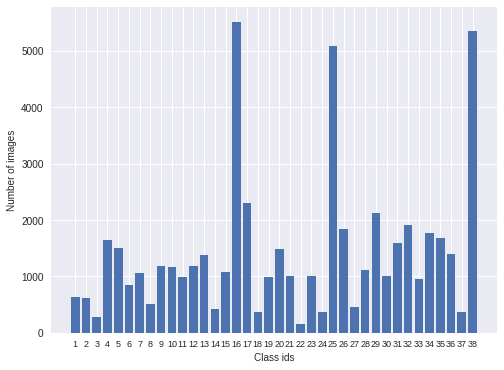

In [191]:
# visualize number of images per each class in dataset
def get_dataset_info(path):
    items = []

    for subdir, dirs, files in os.walk(path):
        for file in files:
            folder_name = os.path.basename(subdir)
            items.append(classes[folder_name])

    return np.asarray(items)


def plot_bar(class_ids, no_images):
    plt.rcParams['figure.figsize'] = (8, 6)
    plt.bar(class_ids, no_images)
    plt.xlabel('Class ids', fontsize=10)
    plt.ylabel('Number of images', fontsize=10)
    plt.xticks(class_ids, [x+1 for x in class_ids], fontsize=9, rotation=0) # corect class index to start from 1
    plt.show()


dataset_info = get_dataset_info('plant-disease-dataset/data/')
num_of_images = len(dataset_info)
print('Number of images in dataset: {}'.format(num_of_images))

class_ids, no_images = np.unique(dataset_info, return_counts=True)
print('\nNumber of images in each class in dataset')
plot_bar(class_ids, no_images)

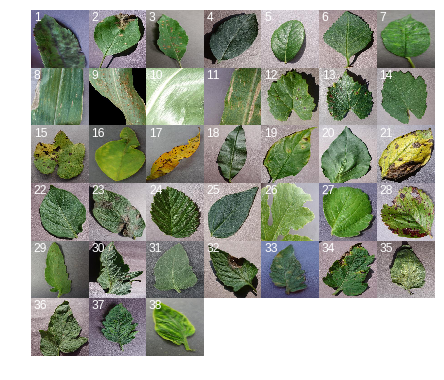

In [187]:
def load_examples(path):
    """ 
    Load an example for each class from the dataset.
    """
    images = []
    labels = []
    
    for subdir, dirs, files in os.walk(path):
        for file in files:
            img = Image.open(os.path.join(subdir, file))
            img = img.resize((224, 224), Image.ANTIALIAS)
            images.append(img)
            
            folder_name = os.path.basename(subdir)
            labels.append(classes[folder_name])

            break      
            
    return images, labels


images, labels = load_examples('plant-disease-dataset/data/')
# sort images by class id
labels, images = zip(*sorted(zip(labels, images)))

# plot loaded data
f, ax = plt.subplots(6, 7)
for i in range(6):
    for j in range(7):
        ax[i,j].axis('off')
        
        idx = (i*7) + j
        if idx < len(images):
            ax[i,j].imshow(images[idx])
            ax[i,j].text(10, 40, labels[idx] + 1, size=12, color='white') # corect class index to start from 1

plt.subplots_adjust(left=0.15, right=0.85, bottom = 0.1, top = 0.9, wspace = 0.0, hspace = 0.0)
plt.show()

In [0]:
def load_data(path):
    items = []
    labels = []
    
    counter = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            img = Image.open(os.path.join(subdir, file))
            img = img.resize((224, 224), Image.ANTIALIAS)
            img_array = np.asarray(img)
            
            # sanitize dimensions
            if (img_array.shape != (224, 224, 3)):
                if img_array.shape[2] > 3:
                    img_array = img_array[:,:,:3] # remove alpha channel
                else:
                    img.close()
                    continue
           
            items.append(img_array)
            img.close()

            folder_name = os.path.basename(subdir)
            labels.append(classes[folder_name])
            
        if len(files) > 0:
            counter += 1
            print('{}/38'.format(counter), end='\r')

    print('\nData successfully loaded')
    items = np.asarray(items)
    labels = np.asarray(labels)

    return items, labels


def load_raw_data(path):
    items = []
    labels = []

    counter = 0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            items.append(os.path.join(subdir, file))

            folder_name = os.path.basename(subdir)
            labels.append(classes[folder_name])

        if len(files) > 0:
            counter += 1
            print('{}/38'.format(counter), end='\r')

    print('\nData successfully loaded')
    items = np.asarray(items)
    labels = np.asarray(labels)

    return items, labels

In [0]:
class DataSequence(Sequence):
    def __init__(self, file_paths, labels, batch_size):
        """
        :param file_paths: list of paths to the images
        :param labels: list of associated classes
        :param batch_size: batch size
        """

        self.file_paths = file_paths
        self.labels = labels
        self.batch_size = batch_size

    def __len__(self):
        return int(np.ceil(len(self.file_paths) / float(self.batch_size)))

    def __getitem__(self, idx):
        batch_x = self.file_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        items = []
        for file_path in batch_x:
            img = Image.open(file_path)
            img = img.resize((224, 224), Image.ANTIALIAS)
            img_array = np.asarray(img)
            
            # sanitize dimensions
            if (img_array.shape != (224, 224, 3)):
                if img_array.shape[2] > 3:
                    img_array = img_array[:,:,:3] # remove alpha channel
                else:
                    img.close()
                    continue
           
            items.append(img_array)
            img.close()
            
        items = np.asarray(items)
        labels = np.asarray(batch_y)
        
        # normalize items
        items = items.astype('float32')
        items /= 255

        return items, labels

### Define model

In [190]:
# config params
batch_size = 64
nb_classes = 38
nb_epoch = 200
data_seq = True

# model construction
model = ResNet50(weights=None, classes=nb_classes)

# load weights
if os.path.exists('drive/plant-disease-detection/weights.hdf5'):
    model.load_weights('drive/plant-disease-detection/weights.hdf5')
    
model.summary()

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath='drive/plant-disease-detection/weights.hdf5', verbose=0, save_weights_only=True)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

### Load data

In [192]:
if data_seq:
    print('Loading raw training data')
    x_train, y_train = load_raw_data('plant-disease-dataset/train/')
    print('Loading raw testing data')
    x_test, y_test = load_raw_data('plant-disease-dataset/test/')

    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
    
    # shuffle train data
    train_shuffle = np.arange(x_train.shape[0])
    np.random.seed(4)
    np.random.shuffle(train_shuffle)
    x_train = x_train[train_shuffle]
    y_train = y_train[train_shuffle]
    # shuffle test data
    test_shuffle = np.arange(x_test.shape[0])
    np.random.seed(4)
    np.random.shuffle(test_shuffle)
    x_test = x_test[test_shuffle]
    y_test = y_test[test_shuffle]
    
    training_seq = DataSequence(x_train, y_train, batch_size)
    validation_seq = DataSequence(x_test, y_test, batch_size)

else:
    print('Loading training data')
    x_train, y_train = load_data('plant-disease-dataset/train/')
    print('Loading testing data')
    x_test, y_test = load_data('plant-disease-dataset/test/')

    # normalize images
    x_train = x_train.astype('float32')
    x_train /= 255
    x_test = x_test.astype('float32')
    x_test /= 255

    # convert class vectors to binary class matrices
    y_train = np_utils.to_categorical(y_train, nb_classes)
    y_test = np_utils.to_categorical(y_test, nb_classes)
                               
    # shuffle train data
    train_shuffle = np.arange(x_train.shape[0])
    np.random.seed(4)
    np.random.shuffle(train_shuffle)
    x_train = x_train[train_shuffle]
    y_train = y_train[train_shuffle]
    # shuffle test data
    test_shuffle = np.arange(x_test.shape[0])
    np.random.seed(4)
    np.random.shuffle(test_shuffle)
    x_test = x_test[test_shuffle]
    y_test = y_test[test_shuffle]

Loading raw training data
38/38
Data successfully loaded
Loading raw testing data
38/38
Data successfully loaded


### Training

In [0]:
# train
if data_seq:
    model.fit_generator(generator=training_seq,
                        steps_per_epoch=(len(x_train) // batch_size),
                        epochs=nb_epoch,
                        verbose=1,
                        validation_data=validation_seq,
                        validation_steps=(len(x_test) // batch_size),
                        callbacks=[checkpointer])
else:
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=nb_epoch,
              validation_data=(x_test, y_test),
              callbacks=[checkpointer])

### Testing

In [36]:
# test
if data_seq:
    score = model.evaluate_generator(generator=validation_seq, steps=(len(x_test) // batch_size))
else:
    score = model.evaluate(x_test, y_test, batch_size=batch_size)  
    
print('Score: {}'.format(score))

Score: [0.03265266746105997, 0.9944526627218935]


### Prediction

In [0]:
# predict
if data_seq:
    predictions = model.predict_generator(generator=validation_seq, steps=(len(x_test) // batch_size))
else:
    predictions = model.predict(x_test, batch_size=batch_size)

print('Predictions: {}'.format(predictions))

In [193]:
# single prediction example
image = Image.open('plant-disease-dataset/test/Grape___Esca_(Black_Measles)/46270bf8-4d82-4c7e-b1ce-b7abfe81b891___FAM_B.Msls 3854.JPG')
image = image.resize((224, 224), Image.ANTIALIAS)

# normalize image
norm_img = np.asarray(image)
norm_img = norm_img.astype('float32')
norm_img /= 255

# predict class for the given image
test = []
test.append(norm_img)
test = np.asarray(test)
predictions = model.predict(test)
expected_class_index = classes['Grape___Esca_(Black_Measles)']
predicted_class_index = np.argmax(predictions[0])
if expected_class_index == predicted_class_index:
    print('Successfully predicted class for the given image ({}).'.format(max(predictions[0])))
else:
    print('Failed to predict correct class for the given image.')

Successfully predicted class for the given image (0.99977046251297).


### Visualization

In [0]:
# import dependencies
from keras import activations
from vis.utils import utils
from vis.visualization import visualize_saliency, overlay
from matplotlib import pyplot as plt

%matplotlib inline

In [0]:
# swapping softmax with linear for better visualization
model.layers[-1].activation = activations.linear
model = utils.apply_modifications(model)

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


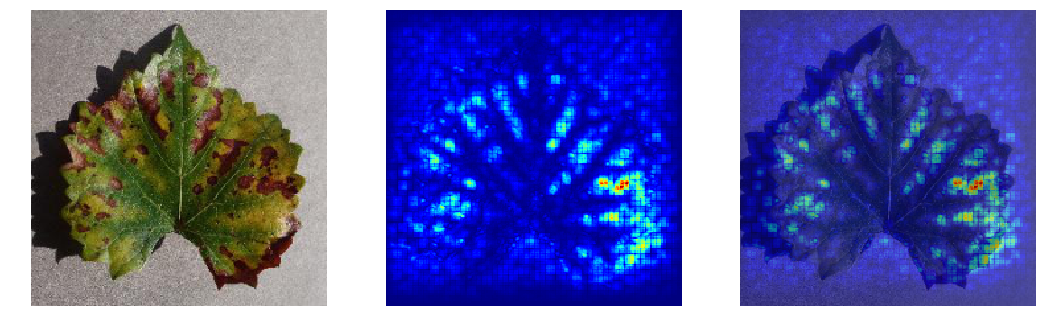

In [42]:
plt.rcParams['figure.figsize'] = (18, 6)
f, ax = plt.subplots(1, 3)

# load image
image = utils.load_img('plant-disease-dataset/test/Grape___Esca_(Black_Measles)/46270bf8-4d82-4c7e-b1ce-b7abfe81b891___FAM_B.Msls 3854.JPG', target_size=(224, 224))

# normalize image
norm_img = np.asarray(image)
norm_img = norm_img.astype('float32')
norm_img /= 255

# plot original image
ax[0].axis('off')
ax[0].imshow(image)

# name of the layer we want to visualize
layer_name = 'fc1000'
layer_idx = utils.find_layer_idx(model, layer_name)

grads = visualize_saliency(model, layer_idx, filter_indices=None, seed_input=norm_img, backprop_modifier='guided')

# plot saliency heatmap  
ax[1].axis('off')
ax[1].imshow(grads, cmap='jet')

# plot saliency heatmap over original image
ax[2].axis('off')
ax[2].imshow(overlay(grads, image, 0.6))